# Batch generator
* Do it inline, read in examples at every time step
* Do you need to have different classes in every batch?

In [25]:
import os
import sys
import glob
import random
import pickle
import numpy as np
from PIL import Image
import time
import copy
from io import BytesIO
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torchvision.models as models

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

SEED = 101
np.random.seed(SEED)
from torchvision import datasets, models, transforms

%reload_ext autoreload
%autoreload 2
%matplotlib inline


# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

# import my functions:
from WSI_utils import*
from WSI_pytorch_utils import*


# Base Directory where data is stored
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'

fast_ai_dir = '/media/rene/Data/fastai/'
sys.path.append(fast_ai_dir)

# Set it to use GPU0
torch.cuda.set_device(1)
print(torch.cuda.is_available())
print(torch.cuda.current_device())

/media/rene/Data/camelyon/src
True
1


## Dataloader
* Do it the way in Detecting Cancer Metastases on Gigapixel Pathology Images
* First select a class (malignant or normal) with p=.5
* Then select a slide of this class, batch_size samples from this tile.
* Include a variable to indicate the acceptable slides to sample from in the training set.

???Is it a problem to have the entire batch of the same class and from the same slide???

* Set epoch size = training set size to 100 000

In [3]:
# class WSIDataset(Dataset):
#     """Sample from the slides indicated by the wsi. 
    
#     Switch turning the imgs to batches into the Dataset rather than the dataloader.
    
#     Standard pytorch dataloader wants to return one img at a time, 
#     so instead set batch_size=1 and return all the imgs at once.
#     Set the length to 100 000

#     Must check if having one batch from the same slide and of one class is a problem
    
#     """
#     SEED = 101
#     random.seed(SEED)

#     def __init__(self, data_loc, normal_nums, tumor_nums, batch_size, length=100000, transforms=None):
#         """nums is a list of """
        
#         all_data = glob.glob(data_loc+'/**/*.tif', recursive=True)  
#         self.normal_locs = [loc for loc in all_data if any(str(x) in loc for x in normal_nums) and 'normal' in loc.lower()]
#         self.tumor_locs = [loc for loc in all_data if any(str(x) in loc for x in tumor_nums) and 'tumor' in loc.lower() and 'mask' not in loc.lower()]
# #         self.tumor_mask_locs = [loc for loc in all_data if any(str(x) in loc for x in tumor_nums) and 'mask' in loc.lower()]
#         self.all_locs = self.normal_locs + self.tumor_locs

#         self.batch_size = batch_size
#         self.length = length
#         self.transforms = transforms

#     def __getitem__(self, index):
#         """Easiest way is to return half of each batch as tumor and non-tumor.
        
#         !!! for now no aug
        
#         We don't care about a sampler method, or the indices. 
#         At each call of __getitem__ we randomly select 2 WSIs. There is no iterating over the dataset.
#         """
        
#         num_tiles = int(self.batch_size/2)
        
#         tumor_loc = random.choice(self.tumor_locs)        
#         tumor_wsi = WSI(tumor_loc)
#         tumor_imgs = tumor_wsi.sample_batch_tumor_region(num_tiles, tile_size=224)
        
#         normal_loc = random.choice(self.all_locs)
#         normal_wsi = WSI(normal_loc)
#         normal_imgs = normal_wsi.sample_batch_normal_region(num_tiles, tile_size=224)

#         batch_imgs = tumor_imgs+normal_imgs
#         labels = [1]*num_tiles + [0]*num_tiles 
        
        
#         if self.transforms is not None:
#             for idx, img in enumerate(batch_imgs):
#                 batch_imgs[idx] = self.transforms(batch_imgs[idx])
        
# #         labels = np.expand_dims(labels, 0) # what is this???
# #         labels = np.expand_dims(labels, 0)
#         return torch.stack(batch_imgs), labels

#     def __len__(self):
#         # we tell pytorch we are using a batch size of 1, so need to scale down the length
#         return int(self.length/self.batch_size)

# # def my_collate(batch):
# #     imgs,targets = zip(*batch)
# #     return torch.cat(imgs),torch.cat(targets)

In [4]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=5, use_gpu=True):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'valid']:
#             if phase == 'train':
#                 scheduler.step()
#                 model.train(True)  # Set model to training mode
#             else:
#                 model.train(False)  # Set model to evaluate mode
#                 model.eval()

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for data in tqdm(dataloaders[phase]):
#                 # get the inputs
#                 inputs, labels = data
#                 labels = torch.stack(labels, 0)
# #                 labels = torch.FloatTensor(labels)
# #                 inputs = torch.from_numpy(inputs).type(torch.FloatTensor)
# #                 print(type(labels[0]))
# #                 labels = torch.type(torch.FloatTensor)

#                 # wrap them in Variable
#                 if use_gpu:
#                     inputs = Variable(inputs.cuda())
#                     labels = Variable(labels.cuda())
#                 else:
#                     inputs, labels = Variable(inputs), Variable(labels)
            
#                 inputs, labels = torch.squeeze(inputs), torch.squeeze(labels)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 outputs = model(inputs)

#                 # for nets that have multiple outputs such as inception
#                 if isinstance(outputs, tuple):
#                     loss = sum((criterion(o,labels) for o in outputs))
#                 else:
#                     loss = criterion(outputs, labels)

#                 # backward + optimize only if in training phase
#                 if phase == 'train':
# #                     _, preds = torch.max(outputs[0].data, 1)
#                     _, preds = torch.max(outputs.data, 1)
#                     loss.backward()
#                     optimizer.step()
#                 else:
#                     _, preds = torch.max(outputs.data, 1)

#                 # statistics
#                 running_loss += loss.data[0] * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
#                 del loss, outputs # Don't know why we need to do this, but some kind of memory leak

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects / dataset_sizes[phase]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'valid' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best valid Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

## Debug
* See if this batch generator produces something similair to the ones used to get above 90% acc.

In [62]:
data_loc = '/media/rene/Data/CAMELYON16/TrainingData'

ttv_split = np.load('/media/rene/Data/camelyon/other/ttv_split.p')
normal_valid = ttv_split['normal_vaild_idx']
tumor_valid = ttv_split['tumor_vaild_idx']

normal_train = list(range(1, 161))
normal_train = [num for num in normal_train if num not in normal_valid]
tumor_train = list(range(1, 111))
tumor_train = [num for num in tumor_train if num not in tumor_valid]

batch_size = 64
epochs = 5
save_path = '/media/rene/Data/camelyon_out/inline_batch/resnet50'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataset_sizes = {}
dataset_sizes['train'] = 10000
dataset_sizes['valid'] = 1000

train_dataset = WSIDataset(data_loc, normal_train, tumor_train, batch_size, length=dataset_sizes['train'], transforms=data_transforms['train'])
valid_dataset = WSIDataset(data_loc, normal_valid, tumor_valid, batch_size, length=dataset_sizes['valid'], transforms=data_transforms['train'])

dataloaders ={}
# collate_fn=my_collate,
dataloaders['train'] = DataLoader(train_dataset,  batch_size=1, num_workers=4, shuffle=False)
dataloaders['valid'] = DataLoader(train_dataset, batch_size=1, num_workers=4, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean:  0.571611
Max:  2.64
Min:  -1.9306722
Mean:  2.2951894
Max:  2.64
Min:  -0.687675
Mean:  0.380427
Max:  2.64
Min:  -1.8781512
Mean:  0.5137158
Max:  2.64
Min:  -1.8431373
Mean:  0.70532405
Max:  2.64
Min:  -1.5280112
Mean:  -0.6272771
Max:  2.2489083
Min:  -2.0357141


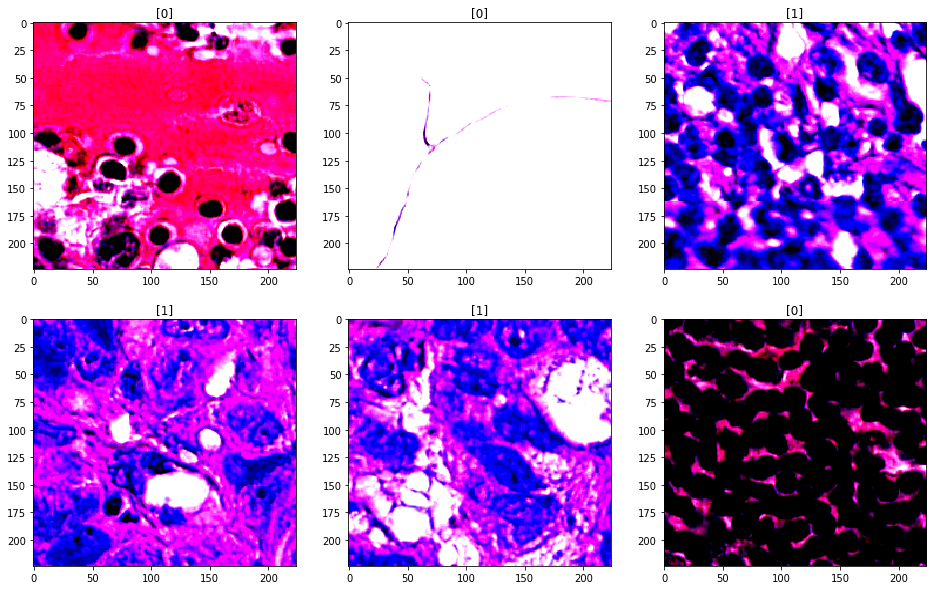

In [66]:
x,y=next(iter(dataloaders['train']))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
x = np.squeeze(x.numpy())

for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5, ax6)):
    img = np.transpose(x[i, :, :, :], (1, 2, 0))
    ax.imshow(img)
    ax.set_title(y[i].numpy())
    ax.set_aspect('auto')
    print('Mean: ', np.mean(img))
    print('Max: ', np.amax(img))
    print('Min: ', np.amin(img))

#### Compare to Fast ai way

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean:  0.8711875
Max:  2.64
Min:  -1.7556022
Mean:  1.7928727
Max:  2.64
Min:  -1.30042
Mean:  -0.6317633
Max:  2.64
Min:  -2.0182073
Mean:  0.36580446
Max:  2.64
Min:  -1.9131652
Mean:  2.1708457
Max:  2.6051416
Min:  1.4611696
Mean:  0.9378774
Max:  2.64
Min:  -1.6680672


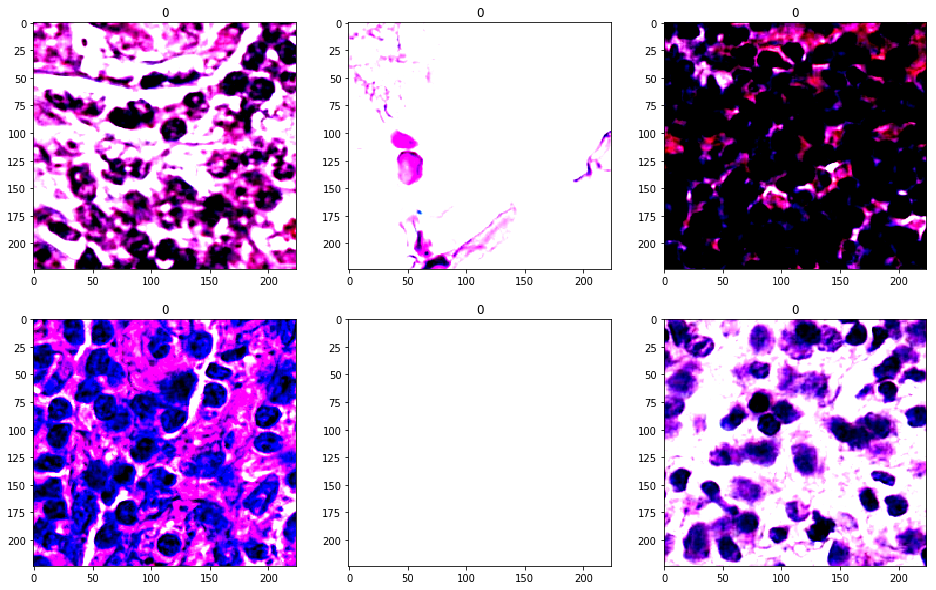

In [67]:
sz=224
arch=resnet50
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), bs=64) 
x,y=next(iter(data.aug_dl))

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
x = np.squeeze(x.cpu().numpy())

for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5, ax6)):
    img = np.transpose(x[i, :, :, :], (1, 2, 0))
    ax.imshow(img)
    ax.set_title(y[i])
    ax.set_aspect('auto')
    print('Mean: ', np.mean(img))
    print('Max: ', np.amax(img))
    print('Min: ', np.amin(img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean:  0.8711875
Max:  2.64
Min:  -1.7556022
Mean:  1.7928727
Max:  2.64
Min:  -1.30042
Mean:  -0.6317633
Max:  2.64
Min:  -2.0182073
Mean:  0.36580446
Max:  2.64
Min:  -1.9131652
Mean:  2.1708457
Max:  2.6051416
Min:  1.4611696
Mean:  0.9378774
Max:  2.64
Min:  -1.6680672


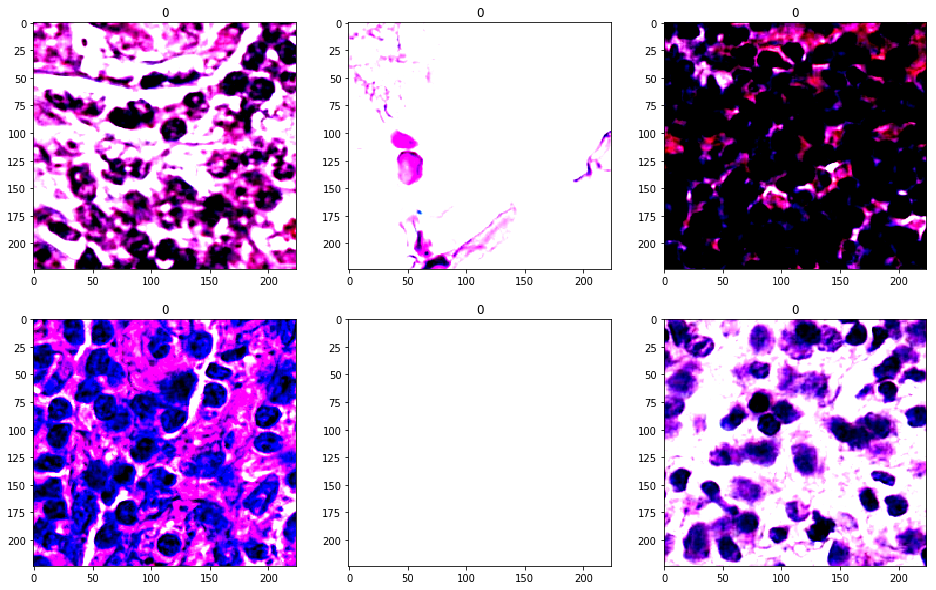

In [68]:
sz=224
arch=resnet50
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), bs=64) 
x,y=next(iter(data.val_dl))

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
x = np.squeeze(x.cpu().numpy())

for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5, ax6)):
    img = np.transpose(x[i, :, :, :], (1, 2, 0))
    ax.imshow(img)
    ax.set_title(y[i])
    ax.set_aspect('auto')
    print('Mean: ', np.mean(img))
    print('Max: ', np.amax(img))
    print('Min: ', np.amin(img))

In [69]:
???

Object `` not found.


In [2]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                   num_epochs=epochs)
torch.save(model_ft.state_dict(), save_path)

NameError: name 'epochs' is not defined

## FAST AI

In [11]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
model_loc = '/media/rene/Data/camelyon_out/inline_batch_random/resnet50_10e_quarter_0'
sz = 224

tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

# model = models.resnet50(pretrained=True)
# model.load_state_dict()
# model.eval()

learn = ConvLearner.pretrained(resnet50, data, precompute=False)
learn.load('/media/rene/Data/camelyon_out/inline_batch_random/resnet50_10e_quarter_0.h5')
preds, y = learn.predict_with_targs(is_test=False)

print(accuracy_np(preds, y))

FileNotFoundError: [Errno 2] No such file or directory: '/media/rene/Data/camelyon_out/inline_batch_random/resnet50_10e_quarter_0.h5.h5'

In [ ]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'

arch=resnet50
tfms = tfms_from_model(arch, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('/media/rene/Data/camelyon_out/tiles_224_100t/models/resnet50_full_fastai')
preds, y = learn.predict_with_targs(is_test=False)
print('100t validation set w/ 100t model: ',accuracy_np(preds, y))



learn = ConvLearner.pretrained(resnet50, data)
learn.load('/media/rene/Data/camelyon_out/inline_batch_random/resnet50_10e_half_0')

preds, y = learn.predict_with_targs(is_test=False)
print('100t validation set w/ 100t model: ',accuracy_np(preds, y))

In [9]:
ttv_split = np.load('/media/rene/Data/camelyon/other/ttv_split.p')
normal_valid = ttv_split['normal_vaild_idx']
tumor_valid = ttv_split['tumor_vaild_idx']
normal_train = list(range(1, 161))
normal_train = [num for num in normal_train if num not in normal_valid]
tumor_train = list(range(1, 111))
tumor_train = [num for num in tumor_train if num not in tumor_valid]

dataset_sizes = {}
dataset_sizes['train'] = 10000
dataset_sizes['valid'] = 1000

data_loc = '/media/rene/Data/CAMELYON16/TrainingData'
batch_size = 64
epochs = 10

tfms_train, tfms_valid = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)
train_dataset = WSIDataset(data_loc, normal_train, tumor_train, batch_size, length=dataset_sizes['train'], transforms=tfms_train)
valid_dataset = WSIDataset(data_loc, normal_valid, tumor_valid, batch_size, length=dataset_sizes['valid'], transforms=tfms_valid)

# dataloaders ={}
# dataloaders['train'] = DataLoader(train_dataset,  batch_size=1, num_workers=4, shuffle=False)
# dataloaders['valid'] = DataLoader(train_dataset, batch_size=1, num_workers=4, shuffle=False)

md.trn_dl.dataset = train_dataset
md.val_dl.dataset = valid_dataset

learn = ConvLearner.pretrained(resnet50, md, precompute=False)
learn.fit(lr, 2, cycle_len=1, cycle_mult=1)

plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

NameError: name 'md' is not defined

In [ ]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, val_idxs=val_idxs)

md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))


**(md) Image - (md)Bounding Box - (md2) Label **

class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))
    
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)


md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

x,y=next(iter(md.val_dl))

ima=md.val_ds.ds.denorm(to_np(x))[1]
b = bb_hw(to_np(y[0][1])); b

ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][1]])

#############
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam